# 上海交通大学BI908《生物医学图像处理》 Lab 1 @王君豪
### SJTU BI908《biomedical image processing》 homework1@your name
-----


## 学生信息（Student information）：
`姓名（Name）：王君豪`

`学号 （ID）：522031910576`

-----

## 作业内容（Contents）：

### 1 读取课程材料中任意 DICOM 文件

In [37]:
import pydicom as dcm
import matplotlib.pyplot as plt
import numpy as np

图像行数: 448
图像列数: 390
存储的比特数: 16
灰度级: 65536


(-0.5, 389.5, 447.5, -0.5)

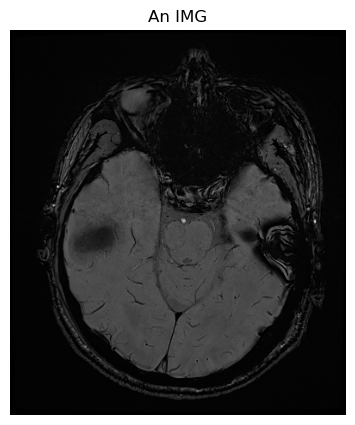

In [38]:
ds = dcm.dcmread("00000045.dcm")
pixelArray = ds.pixel_array

rows = ds.Rows
columns = ds.Columns
bitsStored = ds.BitsStored

print(f"图像行数: {rows}")
print(f"图像列数: {columns}")
print(f"存储的比特数: {bitsStored}")

grayscaleLevels = 2 ** bitsStored
print(f"灰度级: {grayscaleLevels}")

plt.figure(figsize=(5, 5))
plt.imshow(pixelArray, cmap=plt.cm.gray)
plt.title("An IMG")
plt.axis('off')  

### 2 改变采样率

In [39]:
def display(original, changed): 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(changed, cmap=plt.cm.gray)
    axes[1].set_title('Change')
    axes[1].axis('off') 
    plt.tight_layout()

In [40]:
def changePpi(pixelArray, row, col, aimPpi):
    pixelChangePpi = np.empty((row, col)) 
    for i in range(0, row, aimPpi):
        for j in range(0, col, aimPpi):
            medianGrey = np.median(pixelArray[i:i+aimPpi, j:j+aimPpi])
            pixelChangePpi[i:i+aimPpi, j:j+aimPpi] = medianGrey
    
    pixelChangePpi = np.interp(pixelChangePpi, 
                                (pixelChangePpi.min(), pixelChangePpi.max()), 
                                (pixelArray.min(), pixelArray.max()))
    pixelChangePpi = pixelChangePpi.astype(int)
    return pixelChangePpi

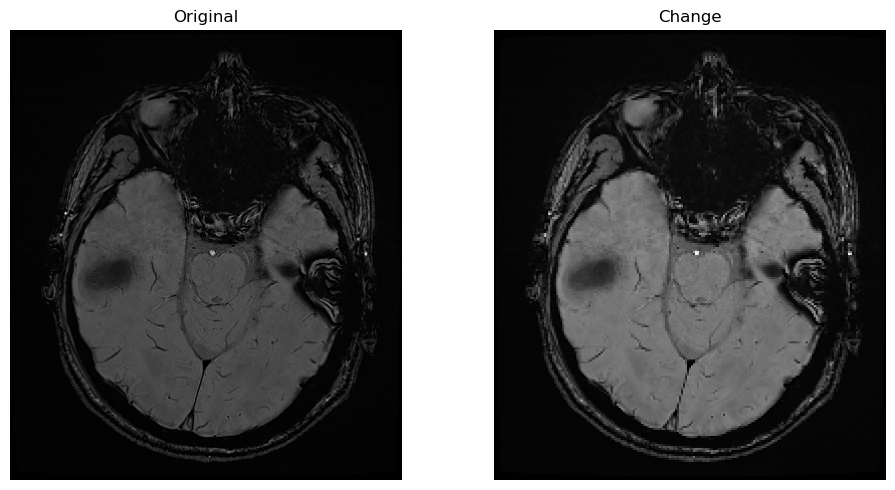

In [41]:
halfPpi = changePpi(pixelArray, rows, columns, 2)
display(pixelArray, halfPpi)

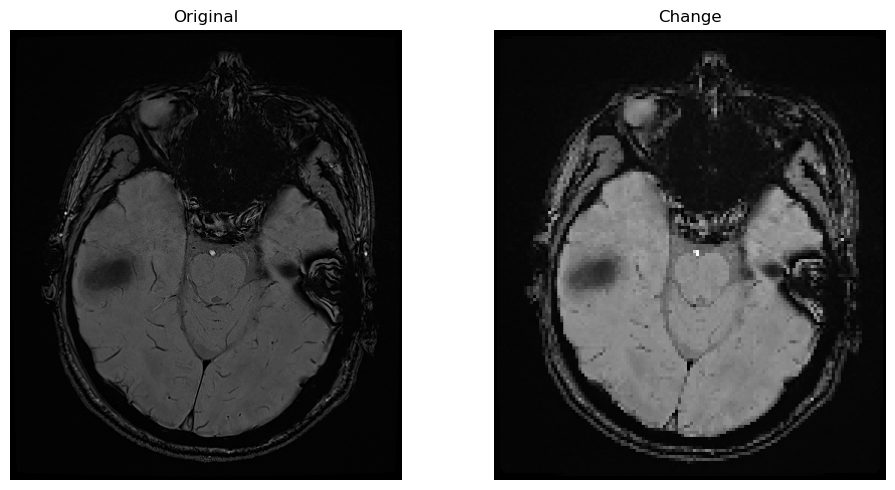

In [42]:
oneThirdPpi = changePpi(pixelArray, rows, columns, 3)
display(pixelArray, oneThirdPpi)

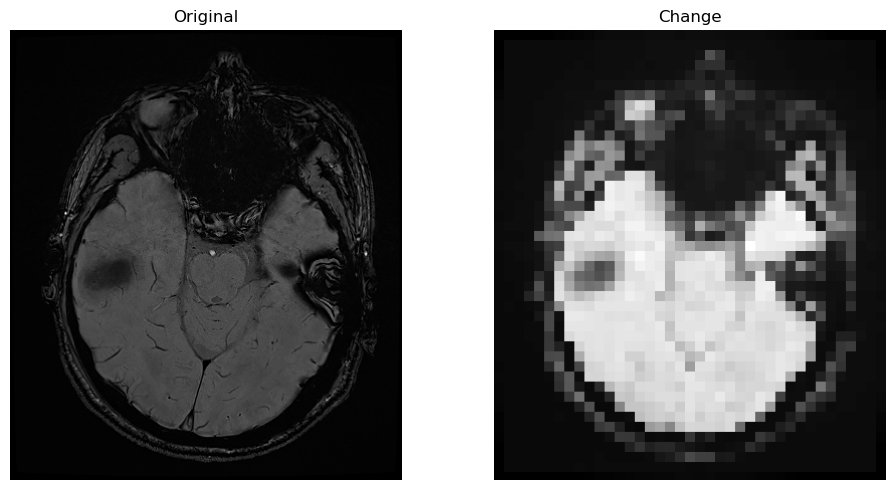

In [43]:
oneTenthPpi = changePpi(pixelArray, rows, columns, 10)
display(pixelArray, oneTenthPpi)

### 3 使用不同的灰度级对图像进行量化并显示对比

In [44]:
def changeGray(pixelArray, aimGray):
    pixelArrayChange = np.array((pixelArray-np.min(pixelArray)) * (aimGray - 1) / (np.max(pixelArray)-np.min(pixelArray)))
    pixelArrayChange = pixelArrayChange.astype(int)
    
    return pixelArrayChange

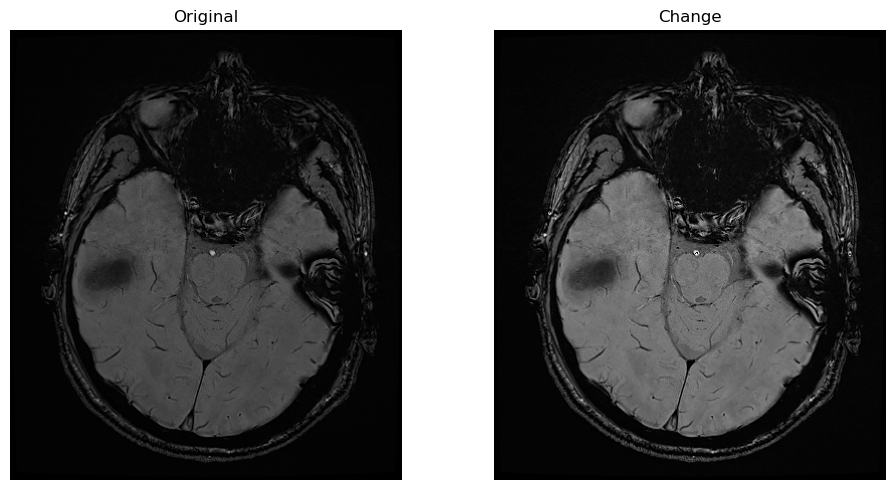

In [45]:
Gray256 = changeGray(pixelArray, 256) #调整为256
display(pixelArray, Gray256)

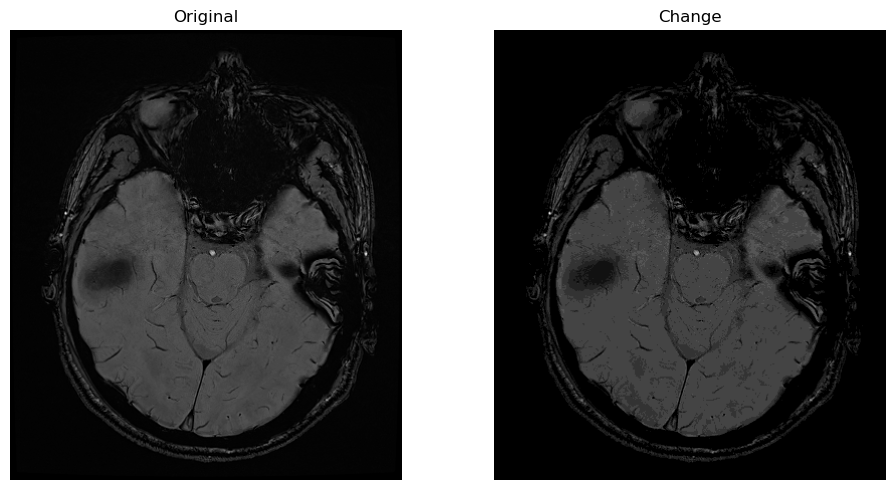

In [46]:
Gray16 = changeGray(pixelArray, 16) #调整为16
display(pixelArray, Gray16)

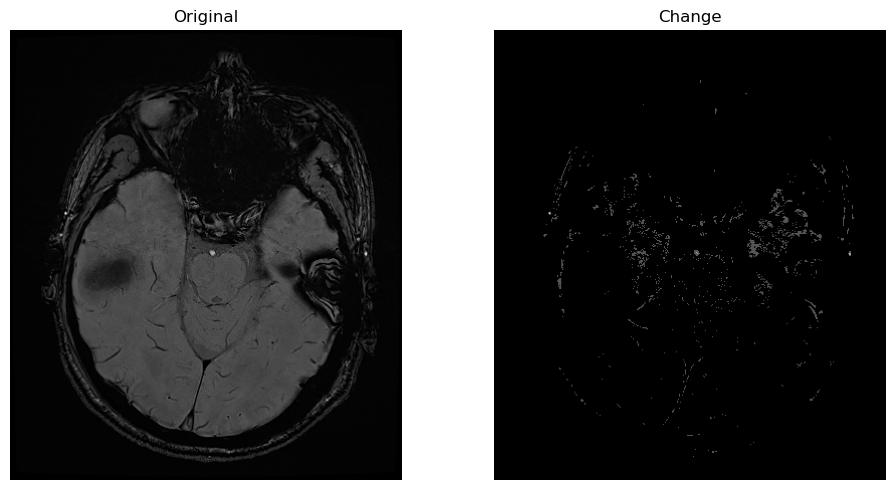

In [47]:
Gray4 = changeGray(pixelArray, 4) #调整为4
display(pixelArray, Gray4)

### 4 运用均值，高斯，中值处理加噪图像并进行结果的对比

边缘处理均为补零

In [48]:
np.max(pixelArray)

392

In [49]:
from scipy.signal import convolve2d

def smoothFilter(pixelArray, row, col, method):
    pixelArray = np.array(pixelArray).astype(np.float32)
    mean = np.array([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]]) / 25    #均值滤波器
    gauss = np.array([
                    [1,  4,  7,  4, 1],
                    [4, 16, 26, 16, 4],
                    [7, 26, 41, 26, 7],
                    [4, 16, 26, 16, 4],
                    [1,  4,  7,  4, 1]
                    ]) / 273                              #高斯滤波器，三个都是5*5的滤波器
    if method == 'mean':
        pixelChange = convolve2d(pixelArray, mean, mode='same', boundary='fill', fillvalue=0)
    if method == 'gauss':
        pixelChange = convolve2d(pixelArray, gauss, mode='same', boundary='fill', fillvalue=0)
    if method == 'median':
        pixelChange = np.empty((row, col))
        for i in range(2, row-2):
            for j in range(2, col-2):
                arr = np.array([
                    [pixelArray[i-2][j-2], pixelArray[i-2][j-1], pixelArray[i-2][j], pixelArray[i-2][j+1], pixelArray[i-2][j+2]],
                    [pixelArray[i-1][j-2], pixelArray[i-1][j-1], pixelArray[i-1][j], pixelArray[i-1][j+1], pixelArray[i-1][j+2]],
                    [pixelArray[i][j-2], pixelArray[i][j-1], pixelArray[i][j], pixelArray[i][j+1], pixelArray[i][j+2]],
                    [pixelArray[i+1][j-2], pixelArray[i+1][j-1], pixelArray[i+1][j], pixelArray[i+1][j+1], pixelArray[i+1][j+2]],
                    [pixelArray[i+2][j-2], pixelArray[i+2][j-1], pixelArray[i+2][j], pixelArray[i+2][j+1], pixelArray[i+2][j+2]],
                ])
                pixelChange[i][j] = np.median(arr)
    #else : return{"no this way"}
    #归一化
    pixelChange = np.interp(pixelChange, 
                                (pixelChange.min(), pixelChange.max()), 
                                (pixelArray.min(), pixelArray.max()))
    pixelChange = pixelChange.astype(int)
    return pixelChange

先加噪声

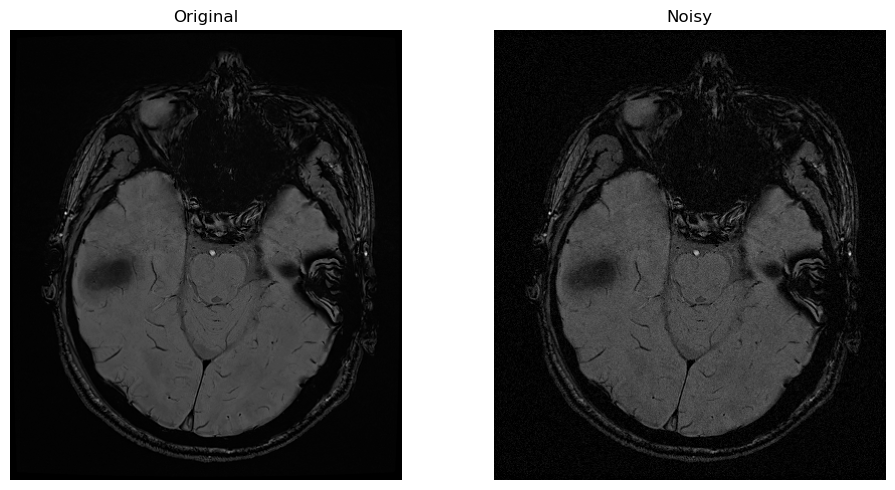

In [50]:
noise = np.random.normal(0, 10, pixelArray.shape).astype(np.int16)
noisyImage = pixelArray + noise
noisyImage = np.clip(noisyImage, 0, np.max(pixelArray))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(pixelArray, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(noisyImage, cmap=plt.cm.gray)
axes[1].set_title('Noisy')
axes[1].axis('off')
plt.tight_layout()
plt.show()

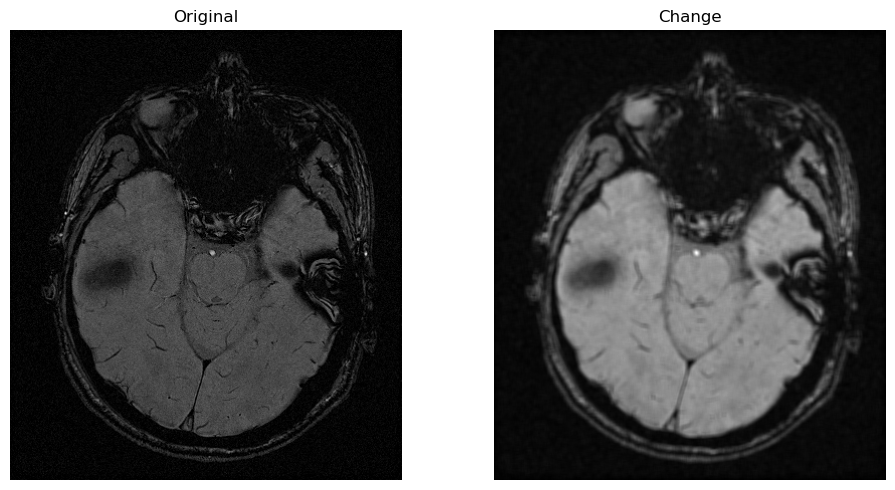

In [51]:
meanPixel = smoothFilter(noisyImage, rows, columns, "mean")  #均值滤波
display(noisyImage, meanPixel)

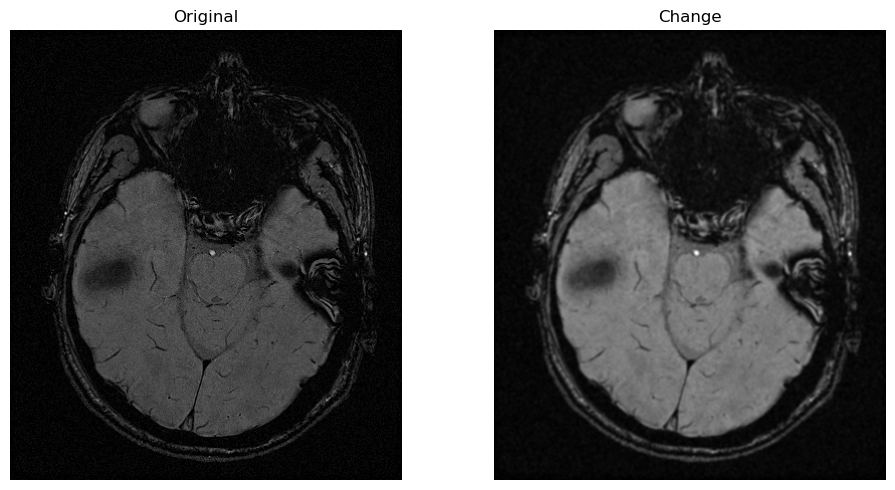

In [52]:
gaussPixel = smoothFilter(noisyImage, rows, columns, "gauss")   #高斯滤波
display(noisyImage, gaussPixel)

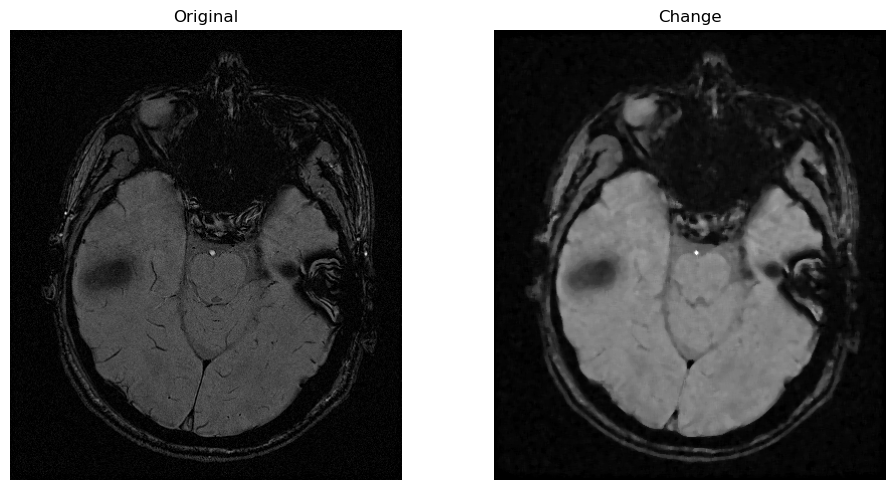

In [53]:
medianPixel = smoothFilter(noisyImage, rows, columns, "median")   #中值滤波
display(noisyImage, medianPixel)

### 5 运用拉普拉斯，非锐化掩蔽， Sobel 处理图像并进行结果的对比

边缘处理均为补零

In [74]:
def sharpFilter(pixelArray, method, k=1):
    
    pixelArray = np.array(pixelArray).astype(np.float32)
    laplace = np.array([[1, 1, 1],[1, -8, 1],[1, 1, 1]])             #laplace滤波器,三个都是3*3的滤波器
    gauss = np.array([
                    [1,  4,  7,  4, 1],
                    [4, 16, 26, 16, 4],
                    [7, 26, 41, 26, 7],
                    [4, 16, 26, 16, 4],
                    [1,  4,  7,  4, 1]
                    ]) / 273                              #非锐化掩蔽处理第一步用的平滑滤波器，高斯平滑
    sobelx = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])   #x掩膜
    sobely = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])   #y掩膜
    if method == 'laplace':
        pixelChange = convolve2d(pixelArray, laplace, mode='same', boundary='fill', fillvalue=0)
        pixelChange = np.clip(pixelChange, 0, None)                            #将灰度<0的截断，全视为0
    if method == 'unsharpMasking':
        pixelSmooth = convolve2d(pixelArray, gauss, mode='same', boundary='fill', fillvalue=0)
        pixelMask = pixelArray - pixelSmooth
        pixelMask = np.clip(pixelMask, 0, None)
        pixelChange = pixelArray + pixelMask * k                               #k是系数 
    if method == 'sobel':
        pixelChangeX = abs(convolve2d(pixelArray, sobelx, mode='same', boundary='fill', fillvalue=0))
        pixelChangeY = abs(convolve2d(pixelArray, sobely, mode='same', boundary='fill', fillvalue=0))
        pixelChange = np.clip(pixelChangeX+pixelChangeY, 0, None)
    #else : return{"no this way"}
    #归一化
    pixelChange = np.interp(pixelChange, 
                                (pixelChange.min(), pixelChange.max()), 
                                (pixelArray.min(), pixelArray.max()))
    pixelChange = pixelChange.astype(int)
    
    return pixelChange

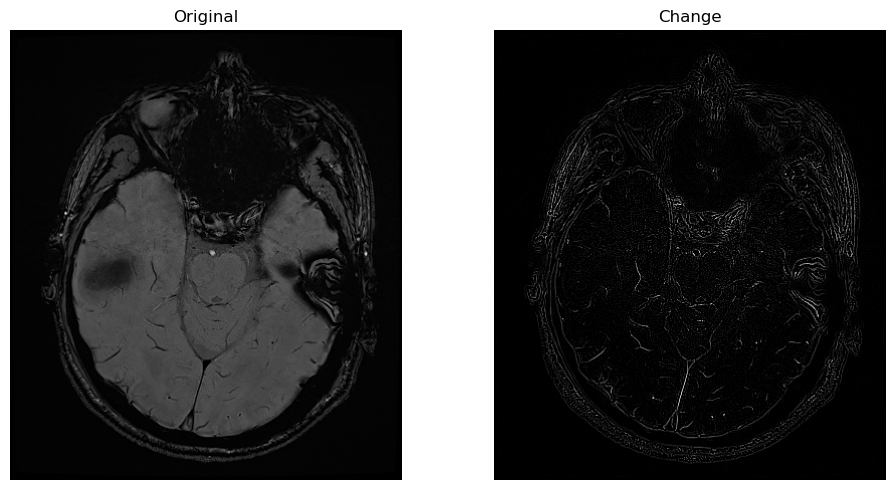

In [75]:
laplacePixel = sharpFilter(pixelArray, "laplace")    #laplace锐化
display(pixelArray, laplacePixel)

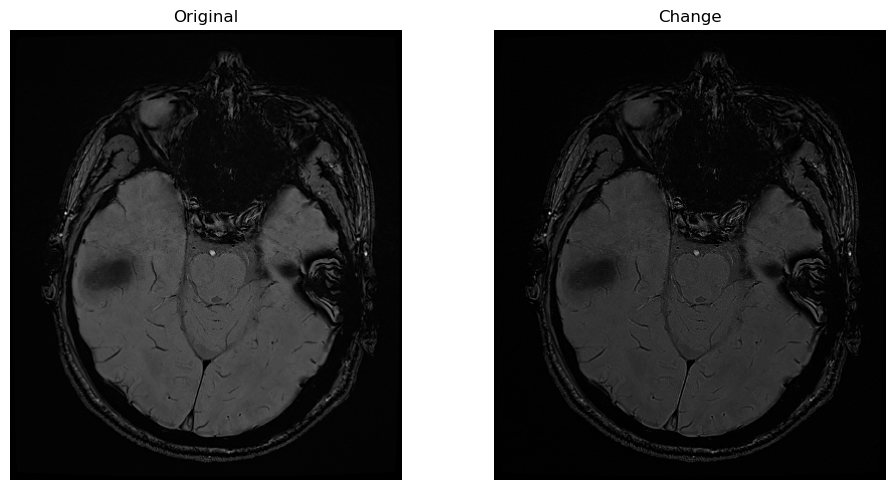

In [76]:
unSharp = sharpFilter(pixelArray, "unsharpMasking")   #非锐化掩蔽
display(pixelArray, unSharp)

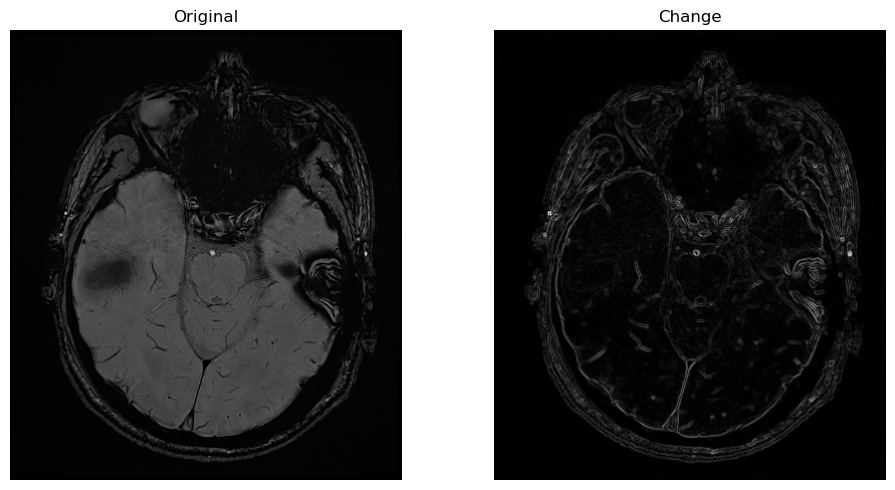

In [77]:
sobelPixel = sharpFilter(pixelArray, "sobel")   #梯度增强sobel算子
display(pixelArray, sobelPixel)

### 6 综合利用图像增强

先显示一下原图和效果图

320 320


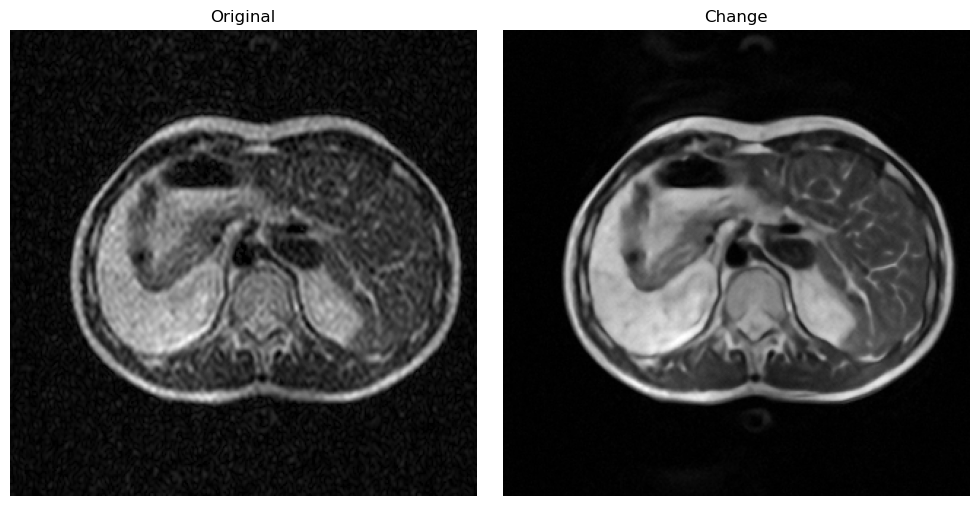

In [58]:
import cv2

pixel = cv2.imread("input.png", cv2.IMREAD_GRAYSCALE)
pixelAim = cv2.imread("output_reference.png", cv2.IMREAD_GRAYSCALE)

display(pixel, pixelAim)

row, col = pixel.shape
print(row,col)

先去噪声，使用平滑滤波器  
先用高斯滤波，后用中值滤波

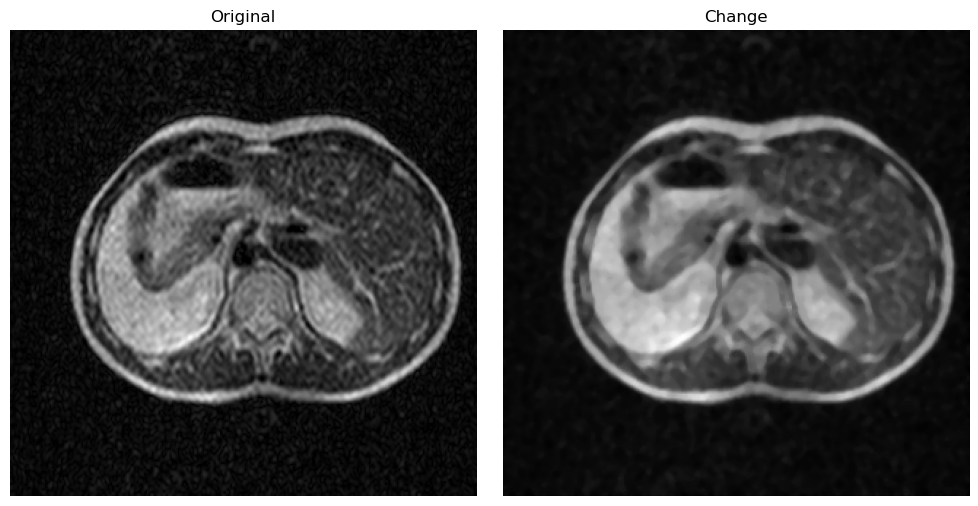

In [59]:
pixelGauss = smoothFilter(pixel, row, col, 'gauss')
pixelMedian = smoothFilter(pixelGauss, row, col, 'median')
display(pixel, pixelMedian)

然后用非锐化掩蔽锐化，Mask的系数设为1.5

本来想用gamma变换后突出亮区的细节，然后用阈值变换直接高亮最后叠加到滤波图像上，但是效果不好，函数不能白写

In [60]:
# def gammaTrans(pixelArray, gamma):
#     pixelChange = pixelArray ** gamma
#     pixelChange = np.interp(pixelChange, 
#                                 (pixelChange.min(), pixelChange.max()), 
#                                 (pixelArray.min(), pixelArray.max()))
#     pixelChange = pixelChange.astype(int)
#     return pixelChange

In [61]:
# pixelGamma = gammaTrans(pixelMedian, 1.5)
# display(pixel, pixelGamma)

In [62]:
# def yuzhiTrans(pixelArray, yuzhi):
#     row, col = pixelArray.shape
    
#     pixelChange = np.zeros((row, col), dtype=pixelArray.dtype)
    
#     pixelChange[pixelArray >= yuzhi] = 200
#     pixelChange[pixelArray < yuzhi] = pixelArray[pixelArray < yuzhi]
    
#     return pixelChange

In [63]:
# pixelYuzhi = yuzhiTrans(pixelGamma, 145)
# display(pixel, pixelYuzhi)

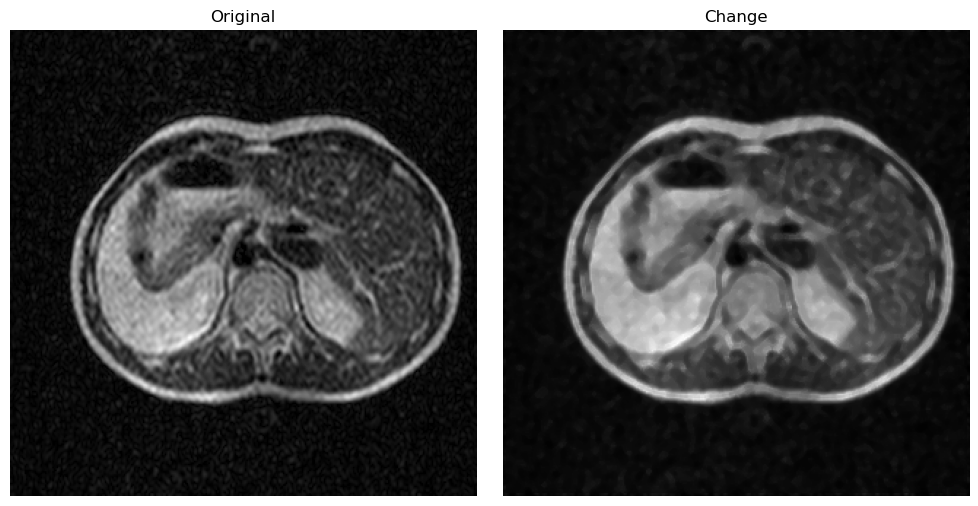

In [64]:
pixelUnsharpMasking = sharpFilter(pixelMedian, 'unsharpMasking', k=1.5)
#pixelFinal = pixelUnsharpMasking + pixelYuzhi
display(pixel, pixelUnsharpMasking)